In [1]:
import numpy as np
import pandas as pd
import json
import cv2
from sklearn.model_selection import train_test_split
import cv2

# tf imports
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.layers import Dense


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPU


loading images with labels

In [3]:
f = open("..\data\measurements.json")
data_json = json.loads(f.read())["Measurements"]

vs = data_json.values()

df = pd.json_normalize(vs)

df.head()


,Variety,RGB_Image,Depth_Information,FreshWeightShoot,DryWeightShoot,Height,Diameter,LeafArea
0,Lugano,RGB_27.png,Depth_27.png,5.5,0.42,9.0,11.0,153.9
1,Lugano,RGB_79.png,Depth_79.png,30.3,1.92,8.8,20.2,582.3
2,Lugano,RGB_140.png,Depth_140.png,60.9,2.83,11.6,19.0,960.6
3,Lugano,RGB_203.png,Depth_203.png,112.0,5.76,11.0,22.0,1614.9
4,Lugano,RGB_292.png,Depth_292.png,372.6,14.17,17.0,32.0,3839.6


In [4]:
import albumentations as alb

def augment(train_set, train_labels, iterations):
    # Define a list of image augmentation transformations to apply
    aug_transforms = [
        alb.HorizontalFlip(),
        alb.VerticalFlip(),
        alb.RandomRotate90(),
        alb.Transpose(),
        alb.RandomBrightnessContrast()
    ]

    # Use the Compose function to apply the transformations
    aug = alb.Compose(aug_transforms)

    # Set the number of times to augment the images
    num_augmentations = iterations

    # Iterate through the number of augmentations
    for i in range(num_augmentations):
      # Iterate through your training set and apply the augmentations to each image
      augmented_train_set = []
      augmented_train_labels = []
      for image, label in zip(train_set, train_labels):
        augmented_image = aug(image=image)['image']
        augmented_train_set.append(augmented_image)
        augmented_train_labels.append(label)

      # Add the augmented images and labels to the training set
      train_set = np.concatenate((train_set, augmented_train_set))
      train_labels = np.concatenate((train_labels, augmented_train_labels))

    # Shuffle the training set and labels
    p = np.random.permutation(len(train_set))
    X = train_set[p]
    y = train_labels[p]
    return X, y


In [5]:
"""
    number: depth=0, RGB=1, depth/RGB=2, augment_data: amount of times for data to be augmented
"""
def prepare_data(number=0, y_key='Height', augment_data=0, normalized = True, split=0.25):

    all_images = []
    y = []

    if number == 2:
        path_RGB = '../data/RGBImagesResize/'
        key_RGB = 'RGB_Image'
        flag_RGB = cv2.IMREAD_COLOR

        path_depth = '../data/DepthImagesResize/'
        key_depth = 'Depth_Information'
        flag_depth = cv2.IMREAD_GRAYSCALE

        for image_path_RGB in os.listdir(path_RGB):
            if df.loc[df[key_RGB] == image_path_RGB][y_key].size > 0:
                img_ID = image_path_RGB.strip(".png").strip("RGB_")
                y.append(df.loc[df[key_RGB] == image_path_RGB][y_key].item())
                img_RGB = cv2.imread(path_RGB + image_path_RGB, flag_RGB)
                img_RGB = cv2.resize(img_RGB, (250, 250))
                image_path_depth = path_depth + "Depth_"+ img_ID + ".png"
                img_depth = cv2.imread(image_path_depth, flag_depth)
                img_depth = cv2.resize(img_depth, (250,250))
                if normalized:
                    img_RGB = img_RGB.astype(np.float32) / 255.0
                    img_depth = img_depth.astype(np.float32) / 255.0

                img_combined = np.dstack((img_RGB, img_depth))
                all_images.append(img_combined)
    else:
        if number == 1:
            path = '../data/RGBImagesResize/'
            key = 'RGB_Image'
            flag = cv2.IMREAD_COLOR
        else:
            path = '../data/DepthImagesResize/'
            key = 'Depth_Information'
            flag = cv2.IMREAD_GRAYSCALE

        for image_path in os.listdir(path):
            if df.loc[df[key] == image_path][y_key].size > 0:
                y.append(df.loc[df[key] == image_path][y_key].item())
                img = cv2.imread(path + image_path, flag)
                img = cv2.resize(img, (250, 250))
                if normalized:
                    img = img.astype(np.float32) / 255.0
                all_images.append(img)


    X_train, X_test, y_train, y_test = train_test_split(np.array(all_images), y, test_size=split, shuffle=True)

    if augment_data > 0:
        X_train, y_train = augment(X_train, y_train, augment_data)

    X_train = tf.convert_to_tensor(X_train)
    X_test = tf.convert_to_tensor(X_test)
    y_train = tf.convert_to_tensor(y_train)
    y_test = tf.convert_to_tensor(y_test)

    return X_train, y_train, X_test, y_test

ResNet Implementation for regression: depth images height

https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba

!!LET OP NIET RUNNEN ZONDER GPU!!

In [6]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, \
    Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from keras import regularizers



In [7]:
def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

In [8]:
def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides=(1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

In [9]:
def create_res_net(input_shape):
    inputs = Input(shape=input_shape)
    num_filters = 64

    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)

    num_blocks_list = [2, 5, 5, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j == 0 and i != 0), filters=num_filters)
        num_filters *= 2

    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    t = Dense(256, activation='relu', activity_regularizer=regularizers.l1(0.001))(t)
    outputs = Dense(1, activation='linear')(t)

    model = Model(inputs, outputs)

    model.compile(
            optimizer='adam',
            loss='mean_squared_error',
            metrics=['mean_absolute_percentage_error']
        )

    return model

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import datetime
import os

def fit_model(model, epochs, batch_size, X_train, y_train, X_test, y_test):
    timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    name = 'res_net'+timestr

    checkpoint_path = "checkpoints/"+name+"/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    os.system('mkdir {}'.format(checkpoint_dir))

    cp_callback = ModelCheckpoint(
        filepath=checkpoint_path,
        verbose=0,
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
    tensorboard_callback = TensorBoard(
        log_dir=f'tensorboard_logs/{name}',
        histogram_freq=1
    )

    model.fit(
        x=X_train,
        y=y_train,
        epochs=epochs,
        verbose=1,
        validation_data=(X_test, y_test),
        batch_size=batch_size,
        callbacks=[cp_callback, tensorboard_callback]
    )

## Using pre-trained network using PyTorch

In [12]:
import torch
import torchvision.models as models
import torch.nn as nn

# Load the pre-trained ResNet-50 model
model = models.resnet34(pretrained=True)

# Replace the final fully connected layer with a new linear layer with a single output
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)
optimizer = torch.optim.Adam(model.parameters())

# use MSE loss
loss_fn = nn.MSELoss()


C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
X_train, y_train, X_test, y_test = prepare_data(1,'Diameter',0, True)

# Convert the TensorFlow tensors to NumPy arrays
X_train = X_train.numpy()
y_train = y_train.numpy()
X_test = X_test.numpy()
y_test = y_test.numpy()

# Convert the NumPy arrays to PyTorch tensors
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

In [45]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.tensorboard import SummaryWriter

# set number of epochs
num_epochs = 100
dataset = TensorDataset(X_train, y_train)
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)
tb = SummaryWriter(log_dir='tensorboard_logs/pytorch_pretrained')
best_val_loss = float('inf')

# training the model
for epoch in range(num_epochs):
    train_loss = 0
    for input, target in dataset:
        optimizer.zero_grad()
        target = target.view(1,1)
        input = input.view(1,3,250,250)
        output = model(input)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(X_train)

    # evaluate the model
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for input, target in zip(X_test, y_test):
            target = target.view(1,1)
            input = input.view(1,3,250,250)
            output = model(input)
            val_loss += loss_fn(output, target).item()
    val_loss /= len(X_test)
    model.train()
    tb.add_scalar('mse', val_loss, epoch)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the best model
        torch.save(model.state_dict(), './checkpoints/pytorch_pretrained/best_model.pt')

tb.close()

Epoch 1/100, Train Loss: 4.5785, Validation Loss: 34.1268
Epoch 2/100, Train Loss: 4.2753, Validation Loss: 50.9374
Epoch 3/100, Train Loss: 4.8575, Validation Loss: 27.1289
Epoch 4/100, Train Loss: 4.5268, Validation Loss: 27.9617
Epoch 5/100, Train Loss: 3.6125, Validation Loss: 33.1183
Epoch 6/100, Train Loss: 3.1051, Validation Loss: 47.6044
Epoch 7/100, Train Loss: 3.0729, Validation Loss: 43.4844
Epoch 8/100, Train Loss: 3.3485, Validation Loss: 24.5663
Epoch 9/100, Train Loss: 3.3427, Validation Loss: 31.6572
Epoch 10/100, Train Loss: 2.3739, Validation Loss: 48.2291
Epoch 11/100, Train Loss: 2.7396, Validation Loss: 47.3213
Epoch 12/100, Train Loss: 2.5490, Validation Loss: 74.6178
Epoch 13/100, Train Loss: 2.2425, Validation Loss: 29.3728
Epoch 14/100, Train Loss: 1.7924, Validation Loss: 56.4869
Epoch 15/100, Train Loss: 2.0237, Validation Loss: 27.7830
Epoch 16/100, Train Loss: 2.1626, Validation Loss: 159.0546
Epoch 17/100, Train Loss: 2.1739, Validation Loss: 44.6114
Epoch

KeyboardInterrupt: 

## Plots predicted vs actual

In [14]:
def plot_true_vs_predicted(predicted, y, title):
    actual = y
    plt.plot(actual, 'bo')
    plt.plot(predicted, 'r^')

    # Draw lines between the data points
    for x1, y1, x2, y2 in zip(range(len(actual)), actual, range(len(predicted)), predicted):
        plt.plot([x1, x2], [y1, y2], 'k-')

    plt.title(title)
    plt.legend(['True data', 'Predicted data'])
    plt.show()


In [17]:
from sklearn.metrics import mean_squared_error, r2_score

def get_metrics(predictions, y):
    # Calculate R2 score
    r2 = r2_score(y, predictions)
    print("R-squared:", r2)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y, predictions))
    print("RMSE:", rmse)

    # Calculate NRMSE
    range = max(y_test) - min(y_test)
    nrmsd = (rmse/range)*100
    print("NRMSE(%):", nrmsd)

Diameter

11/11 [==============================] - 8s 787ms/step
R-squared: 0.9234330047149365
RMSE: 1.758999
NRMSE(%): tf.Tensor(5.204139, shape=(), dtype=float32)


C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


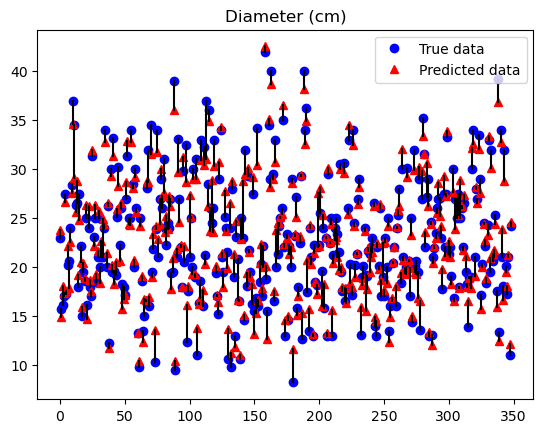

In [22]:
X_train, y_train, X_test, y_test = prepare_data(1,'Diameter',0, True, 0.9)
model = tf.keras.models.load_model('./checkpoints/rgb_augm_reg_diameter/cp-0029.ckpt')
predicted = model.predict(X_test)

get_metrics(predicted, y_test)
plot_true_vs_predicted(predicted, y_test, 'Diameter (cm)')

Height

2/2 [==============================] - 2s 2s/step
R-squared: 0.9595587997986785
RMSE: 1.0158398
NRMSE(%): tf.Tensor(5.675083, shape=(), dtype=float32)


C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


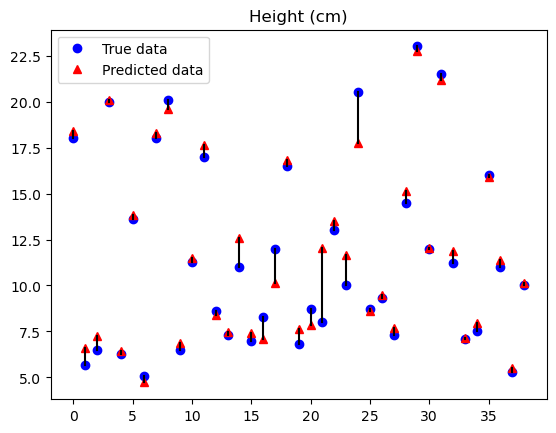

In [32]:
X_train, y_train, X_test, y_test = prepare_data(0,'Height',0, True, 0.1)
model = tf.keras.models.load_model('./checkpoints/depth_reg_height/cp-0098.ckpt')

predicted = model.predict(X_test)

get_metrics(predicted, y_test)
plot_true_vs_predicted(predicted, y_test, 'Height (cm)')

Fresh Weight

4/4 [==============================] - 2s 517ms/step
R-squared: 0.973895412112714
RMSE: 17.337967
NRMSE(%): tf.Tensor(4.087215, shape=(), dtype=float32)


C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


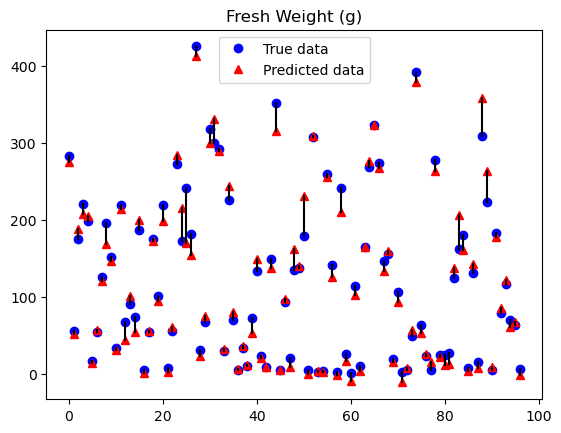

In [25]:
X_train, y_train, X_test, y_test = prepare_data(2,'FreshWeightShoot',0, False)
model = tf.keras.models.load_model('./checkpoints/rgb-d_freshweight/cp-0100.ckpt')
predicted = model.predict(X_test)

get_metrics(predicted, y_test)
plot_true_vs_predicted(predicted, y_test, 'Fresh Weight (g)')

Dry Weight

4/4 [==============================] - 2s 610ms/step
R-squared: 0.9453063349237353
RMSE: 1.1188064
NRMSE(%): tf.Tensor(6.1744285, shape=(), dtype=float32)


C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


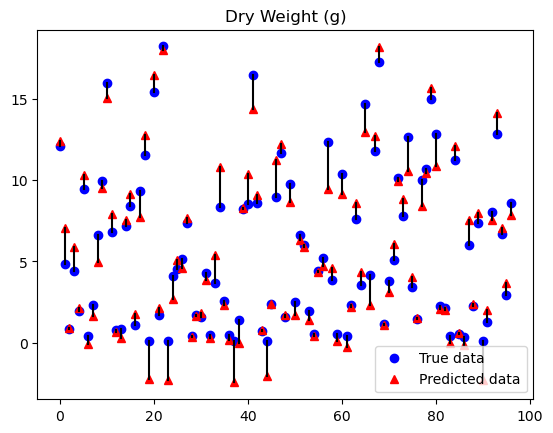

In [29]:
X_train, y_train, X_test, y_test = prepare_data(1,'DryWeightShoot',0, False)
model = tf.keras.models.load_model('./checkpoints/rgb_dryweight/cp-0077.ckpt')
predicted = model.predict(X_test)

get_metrics(predicted, y_test)
plot_true_vs_predicted(predicted, y_test, 'Dry Weight (g)')

Leaf Area

4/4 [==============================] - 2s 562ms/step
R-squared: 0.9419679252723223
RMSE: 325.66714
NRMSE(%): tf.Tensor(6.035008, shape=(), dtype=float32)


C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


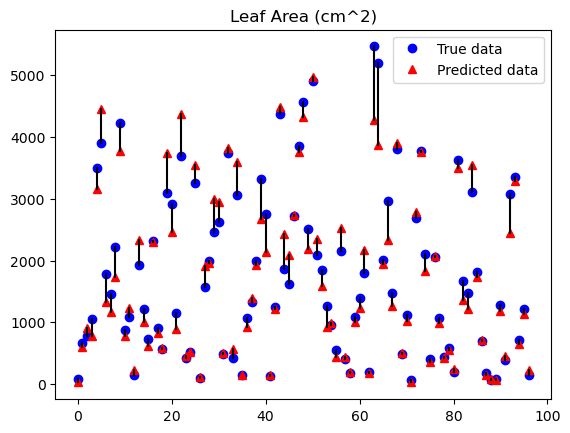

In [30]:
X_train, y_train, X_test, y_test = prepare_data(1,'LeafArea',0, True)
model = tf.keras.models.load_model('./checkpoints/rgb_augm_reg_leafarea/cp-0035.ckpt')
predicted = model.predict(X_test)

get_metrics(predicted, y_test)
plot_true_vs_predicted(predicted, y_test, 'Leaf Area (cm^2)')